# Stock Analysis
Moving average stretegy research
    

### 1. Data Collection:

In [35]:
import yfinance as yf 
import backtrader as bt
import pandas_ta as ta
import pandas as pd

In [36]:
data = yf.download('SBIN.NS', start='2020-01-01', end='2024-05-21')
print(data.tail())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-05-13  819.849976  819.849976  798.599976  808.799988  808.799988   
2024-05-14  813.000000  822.400024  807.900024  818.200012  818.200012   
2024-05-15  821.000000  825.299988  818.049988  820.299988  820.299988   
2024-05-16  825.299988  826.150024  797.349976  811.950012  811.950012   
2024-05-17  814.500000  822.450012  811.200012  817.849976  817.849976   

              Volume  
Date                  
2024-05-13  15398505  
2024-05-14  10912462  
2024-05-15   9755062  
2024-05-16  20536990  
2024-05-17  12492509  


In [37]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [38]:
# checking for null values
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## data preprocessing

In [39]:
# adding 20, 50, 200 moving averages
data['5 MA'] = ta.ema(data['Close'], length=5)
data['20 MA'] = ta.ema(data['Close'], length=20)
data['50 MA'] = ta.ema(data['Close'], length=50)
data['200 MA'] = ta.ema(data['Close'], length=200)

# adding percentage change
data['Pct_change'] = data['Close'].pct_change()

# adding target
data['target'] = data['Close'].shift(-1)

## EDA

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

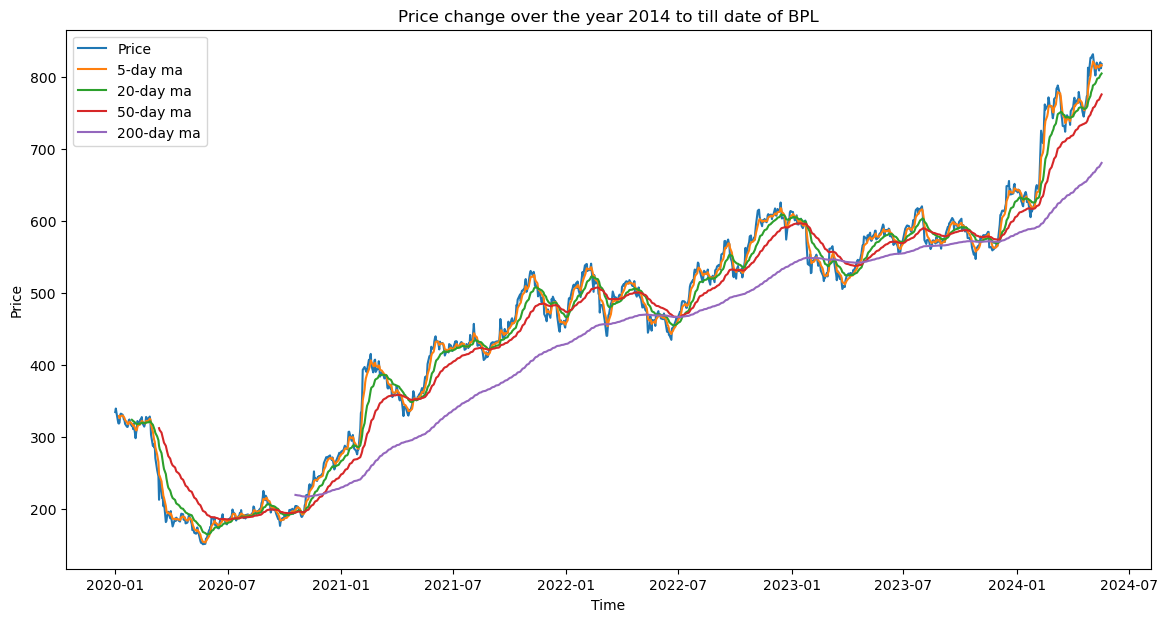

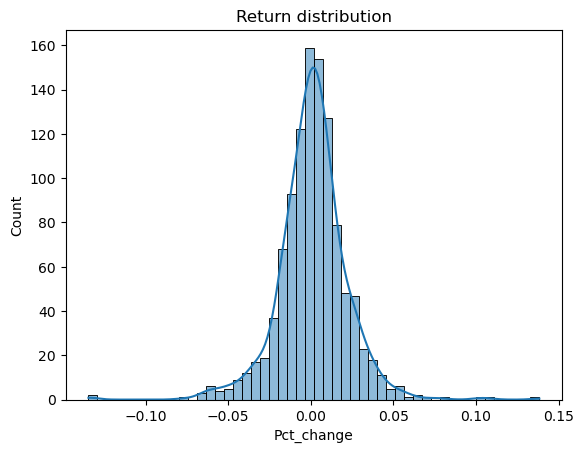

In [41]:
# viuslaizing price and moving averages
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Price')
plt.plot(data['5 MA'], label="5-day ma")
plt.plot(data['20 MA'], label='20-day ma')
plt.plot(data['50 MA'], label='50-day ma')
plt.plot(data['200 MA'], label='200-day ma')
plt.title("Price change over the year 2014 to till date of BPL")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


sns.histplot(data['Pct_change'].dropna(), bins=50, kde=True)
plt.title("Return distribution")
plt.show()

## features engineering

In [42]:
data['volatility'] = data['Pct_change'].rolling(window=21).std() * (252**0.5)     # Annualized volatility 


## Training Predictive Model

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [44]:
# cleaning data
data.dropna(inplace=True)
data.isnull().sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
5 MA          0
20 MA         0
50 MA         0
200 MA        0
Pct_change    0
target        0
volatility    0
dtype: int64

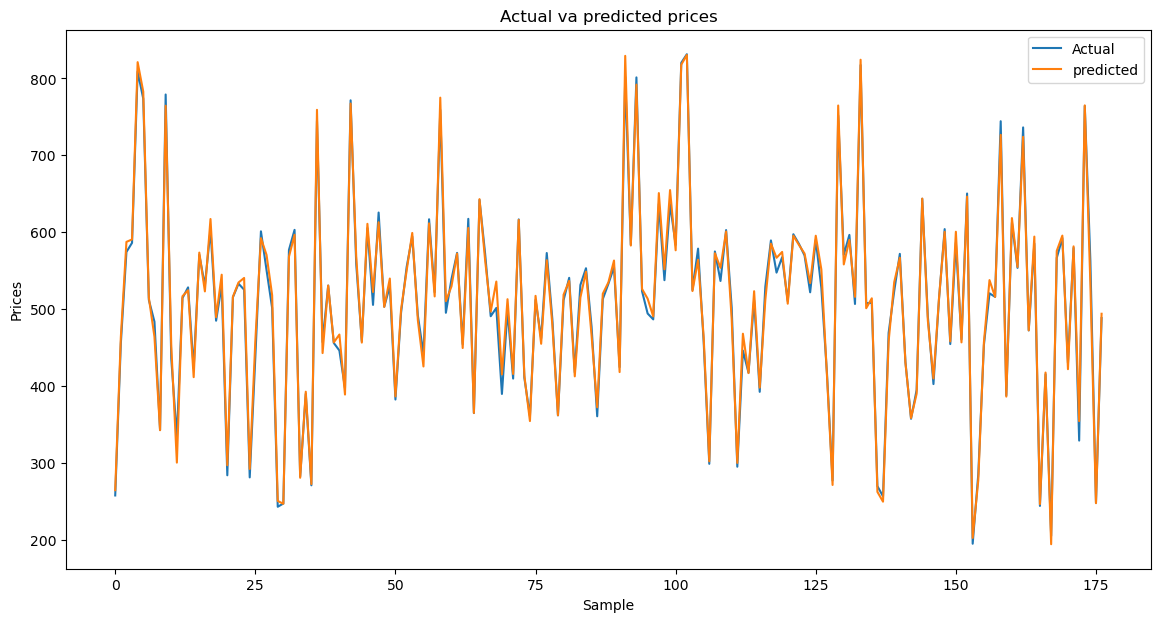

In [45]:
X = data[['Volume', '5 MA', '20 MA', '50 MA', '200 MA', 'volatility']]
y = data['target']

# spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# make prediction
prediction = lin_model.predict(X_test)


# evaluating model
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(prediction, label="predicted")
plt.title("Actual va predicted prices")
plt.xlabel("Sample")
plt.ylabel("Prices")
plt.legend()
plt.show()

## Backtesting stretegy

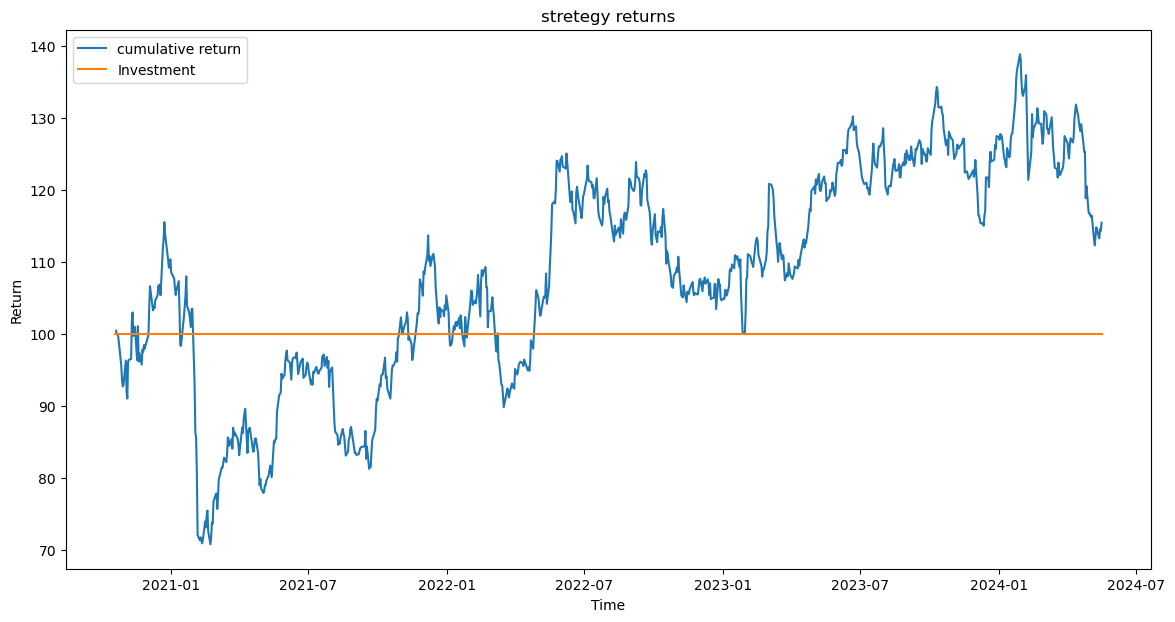

In [54]:
def backtest(data, model):
    data = data.copy()
    data['predicted'] = model.predict(data[['Volume', '5 MA', '20 MA', '50 MA', '200 MA', 'volatility']])
    data['signal'] = 0
    data.loc[data['predicted'] > data['Close'], "signal"] = 1    # buy signal
    data.loc[data['predicted'] < data['Close'], "signal"] = -1    # sell signal
    data['Stretegy Return'] = data['Pct_change'] * data['signal'].shift(1) 
    cumulative_return  = (data['Stretegy Return'] + 1).cumprod()
    return cumulative_return * 100

cum_return  = backtest(data, lin_model)
plt.figure(figsize=(14, 7))
plt.plot(cum_return, label='cumulative return')
plt.plot(pd.Series([100 for i in range(len(cum_return))], index=cum_return.index), label="Investment")
plt.title("stretegy returns")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.show()
